<a href="https://colab.research.google.com/github/LeoVal1/Semantic_Segmentation/blob/main/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from IPython.display import clear_output
import matplotlib.pyplot as plt
import Utility
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, Conv2DTranspose, MaxPooling2D

##Import Datasets

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteAR88VU/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteAR88VU/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask
  
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

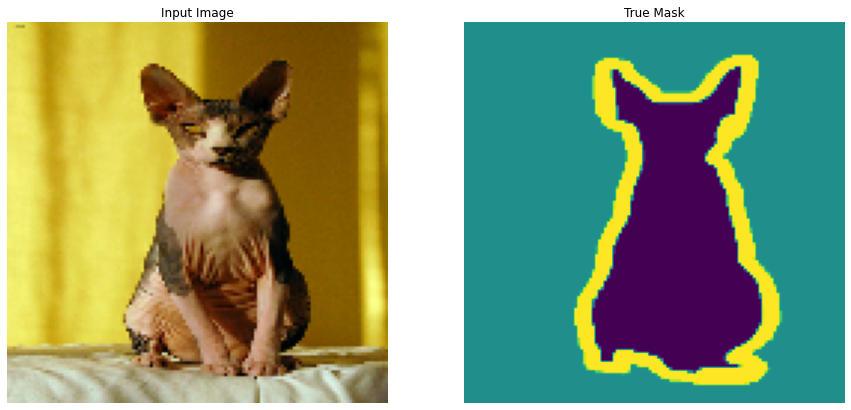

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(Utility.load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(Utility.load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

for image, mask in train.take(5):
  sample_image, sample_mask = image, mask
Utility.display([sample_image, sample_mask])

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

In [ ]:
model = tf.keras.Sequential([
# build your CNN model here
Conv2D(filters=16, kernel_size=(3,3), strides=2, padding='same', activation='relu', input_shape=(128,128,3)),
Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=(64,64,16)),
MaxPooling2D(2),
Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=(32,32,32)),
Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, padding='same'),
Conv2DTranspose(3, kernel_size=(3,3), strides=2, padding='same'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 3)      1

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])# enter the parameter by yourself

In [ ]:
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[Utility.DisplayCallback()])


Sample Prediction after epoch 20

115/115 [==============================] - 79s 692ms/step - loss: 0.5677 - accuracy: 0.7561 - val_loss: 0.5707 - val_accuracy: 0.7592


In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss =model_history.history['val_loss']
print('Traning Accuracy')
print(acc)
print('Validation Accuracy')
print(val_acc)
print('Training loss')
print(loss)
print('Validation loss')
print(val_loss)

Traning Accuracy
[0.592768669128418, 0.6414299607276917, 0.6738604307174683, 0.6956165432929993, 0.7093876600265503, 0.717609703540802, 0.7199127674102783, 0.7280474901199341, 0.7273927330970764, 0.733925461769104, 0.7329587936401367, 0.7366580367088318, 0.7443014979362488, 0.7461655139923096, 0.7477090954780579, 0.7472957372665405, 0.752914547920227, 0.7537219524383545, 0.7563381195068359, 0.7561019659042358]
Validation Accuracy
[0.631997287273407, 0.6576305627822876, 0.6956866979598999, 0.7094058394432068, 0.7175672650337219, 0.7211633920669556, 0.7256478667259216, 0.7310224771499634, 0.7327304482460022, 0.7158679366111755, 0.7283359169960022, 0.7459011077880859, 0.7485277056694031, 0.7476187348365784, 0.7526797652244568, 0.7504348754882812, 0.7603855133056641, 0.753491997718811, 0.7583944797515869, 0.7592213153839111]
Training loss
[0.8735660910606384, 0.7686898112297058, 0.7165843844413757, 0.6815208792686462, 0.6561902165412903, 0.6430196166038513, 0.6369666457176208, 0.6228410601

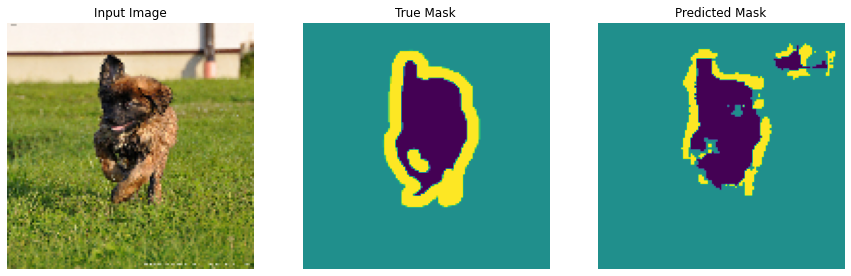

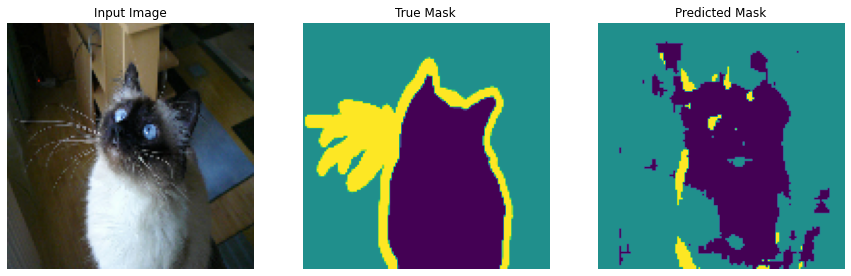

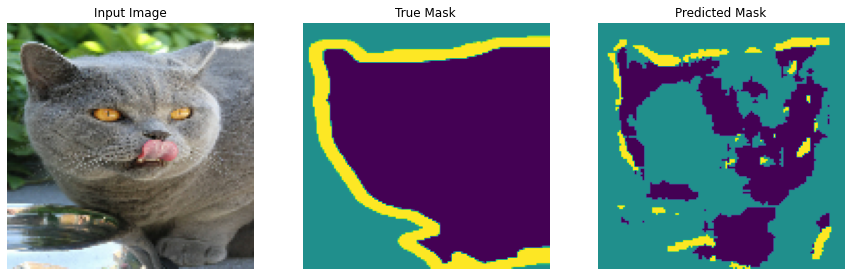

In [ ]:
title = ['Input Image', 'True Mask', 'Predicted Mask']
 
for image, mask in test_dataset.take(3):
    pred_mask = model.predict(image)
    Utility.display([image[0], mask[0], Utility.create_mask(pred_mask)])

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

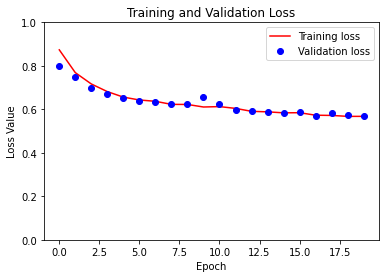

In [ ]:
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


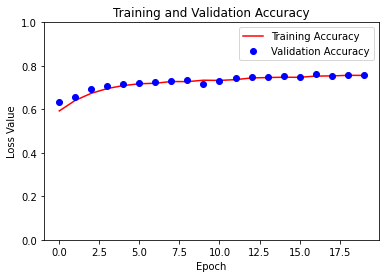

In [ ]:
plt.figure()
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'bo', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()
